# Sentiment Analysis of Employee Review

### This Project is used to understand the main variables affecting the attrition rates in dream companies like Google, Amazon, Facebook and Apple. 

### We will first clean the data and prepare it for processing. We will later conduct some exploratory data analysis to understand the data better. We will then build various models to predict the satisfaction level of an employee. 


In [ ]:
|Importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Loading the Employee Reviews dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving employee_reviews.csv to employee_reviews (1).csv


In [ ]:
# Load csv file
data = pd.read_csv('employee_reviews.csv')
# viewing an excerpt of the data
data.head()

Unnamed: 0  ...                                               link
0           1  ...  https://www.glassdoor.com/Reviews/Google-Revie...
1           2  ...  https://www.glassdoor.com/Reviews/Google-Revie...
2           3  ...  https://www.glassdoor.com/Reviews/Google-Revie...
3           4  ...  https://www.glassdoor.com/Reviews/Google-Revie...
4           5  ...  https://www.glassdoor.com/Reviews/Google-Revie...

[5 rows x 17 columns]

### Descriptive Analytics for the data

In [ ]:
#Knowing the data
print("\nTotal number of reviews: ",len(data))
print("\nTotal number of companies: ", len(data['company'].unique()))
print("\nTypes of employee positions: ", len(list(set(data['job-title']))))


Total number of reviews:  67529

Total number of companies:  6

Types of employee positions:  8308


### Data Cleaning and Feature Engineering

In [ ]:
#checking data types
data.dtypes

Unnamed: 0                      int64
company                        object
location                       object
dates                          object
job-title                      object
summary                        object
pros                           object
cons                           object
advice-to-mgmt                 object
overall-ratings               float64
work-balance-stars             object
culture-values-stars           object
carrer-opportunities-stars     object
comp-benefit-stars             object
senior-mangemnet-stars         object
helpful-count                   int64
link                           object
dtype: object

In [ ]:
#checking number of nulls in data source
for i in data.columns.values:
    if data[i].isnull().sum() > 0:
        print('{}  {}'.format(i , data[i].isnull().sum()))


#impute values for NULL
data['advice-to-mgmt'] = data['advice-to-mgmt'].fillna('None')

summary  120
advice-to-mgmt  297


In [ ]:
#converting ratings column data type into numeric
convert_dtype = ['work-balance-stars' , 'culture-values-stars' , 'carrer-opportunities-stars',
                     'comp-benefit-stars','senior-mangemnet-stars', 'helpful-count']
for i in convert_dtype: 
    data[i] = data[i].replace('none' , 0)
    data[i] =  data[i].astype(np.float32)

data.dtypes

Unnamed: 0                      int64
company                        object
location                       object
dates                          object
job-title                      object
summary                        object
pros                           object
cons                           object
advice-to-mgmt                 object
overall-ratings               float64
work-balance-stars            float32
culture-values-stars          float32
carrer-opportunities-stars    float32
comp-benefit-stars            float32
senior-mangemnet-stars        float32
helpful-count                 float32
link                           object
dtype: object

In [ ]:
#describing the States in the data set
data["location"].value_counts()

none                 25085
Redmond, WA           5613
Seattle, WA           4963
Hyderabad (India)     2150
Mountain View, CA     1706
                     ...  
Somerville, MA           1
Raheny (Ireland)         1
Penn Hills, PA           1
Zaragoza (Spain)         1
Victoria (Chile)         1
Name: location, Length: 2044, dtype: int64

In [ ]:
_#extracting state
def get_state(x):
    if "(" in x:
        x = x.split("(")[1]
        x = x.split(")")[0]
    elif ", " in x:
        x = x.split(", ")[-1]

    return x

data["state"] = data["location"].apply(lambda x: get_state(x))
data.head(3)

Unnamed: 0 company  ...                                               link state
0           1  google  ...  https://www.glassdoor.com/Reviews/Google-Revie...  none
1           2  google  ...  https://www.glassdoor.com/Reviews/Google-Revie...    CA
2           3  google  ...  https://www.glassdoor.com/Reviews/Google-Revie...    NY

[3 rows x 18 columns]

In [ ]:
#dropping unnecessary columns like links of the reviews
data.drop(columns=['link','Unnamed: 0'], inplace=True)

In [ ]:
#extracting the year 
data['year'] = data['dates'].str.split(", ").str[1]

### Data Visualization

Text(0, 0.5, 'Count')

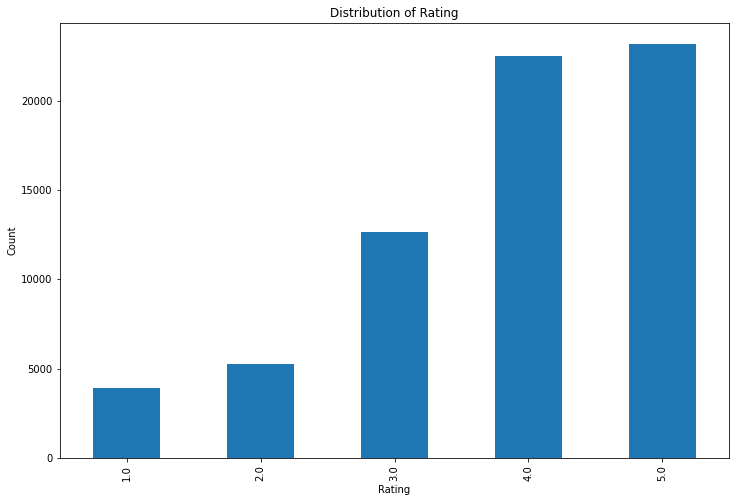

In [ ]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
data['overall-ratings'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

We can see from the above plot that the overall ratings are more positive for the companies. 

Text(0.5, 1.0, 'Number of Reviews for the 6 Companies')

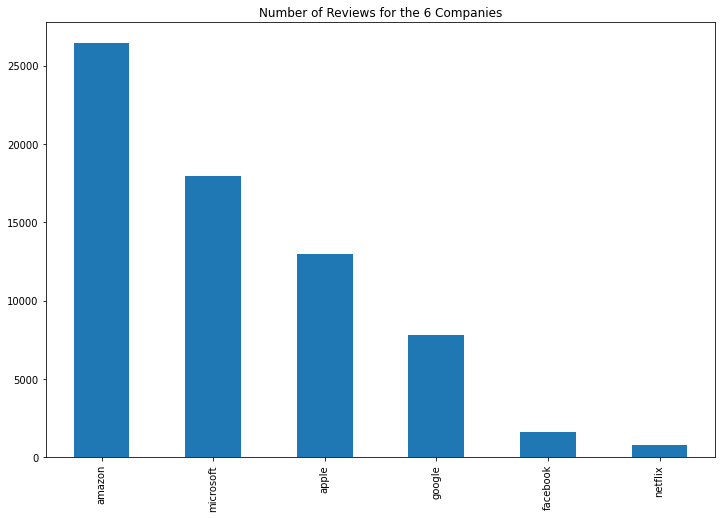

In [ ]:
# Plot number of reviews for companies
company = data["company"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
company.plot(kind='bar')
plt.title("Number of Reviews for the 6 Companies")

We can see here that amazon has the most number of reviews in the data set , while Netflix hs the least number of reviews submitted. 

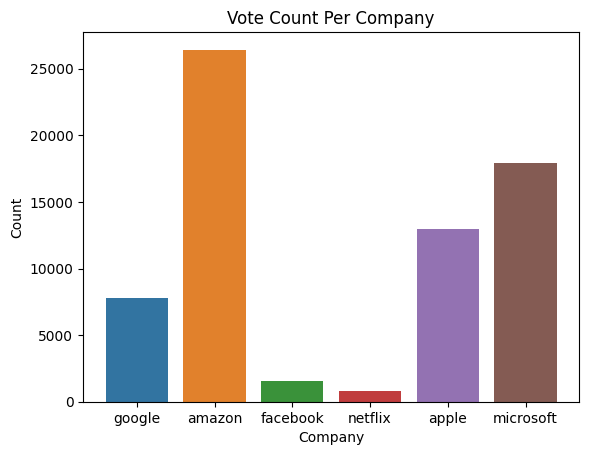

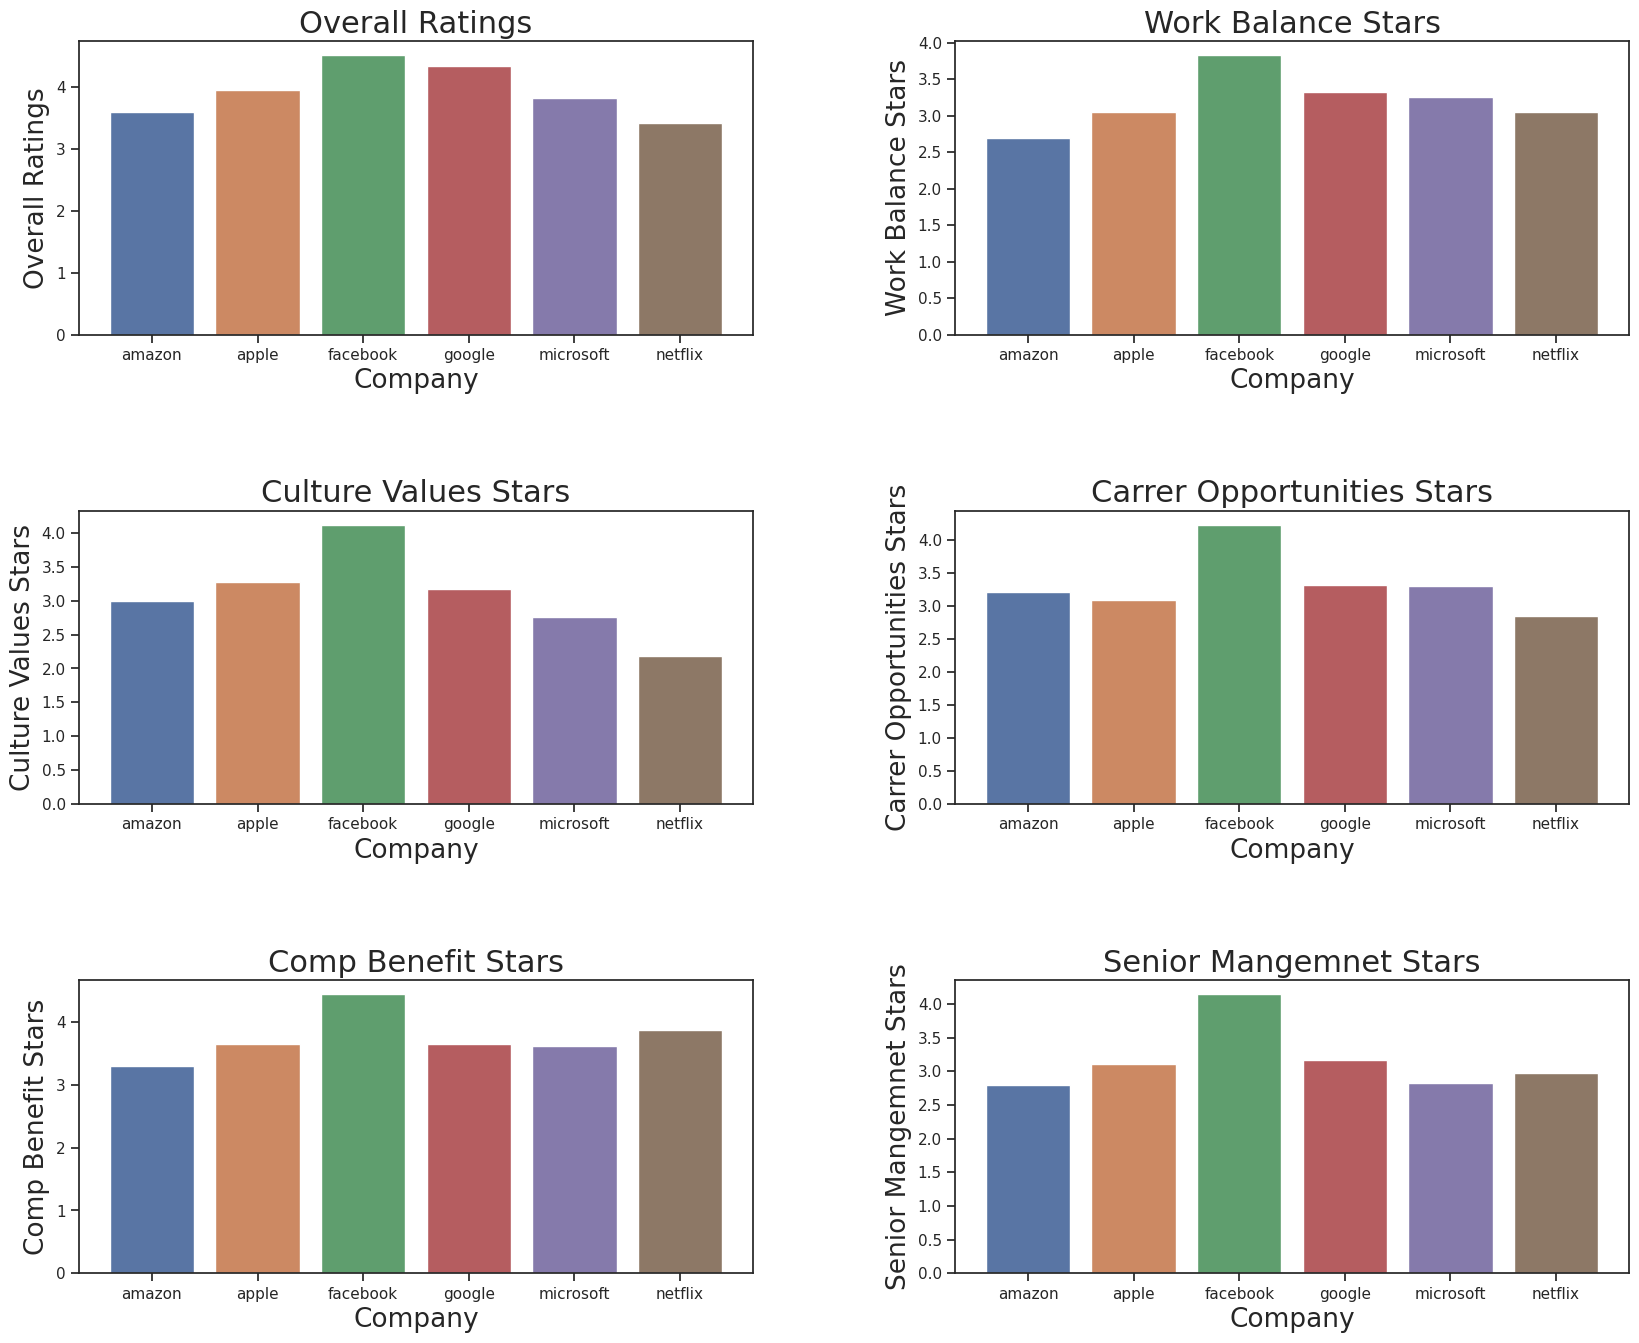

In [ ]:
# Plot distribution of ratings for each catefgory of ratings given to companies
rating_cols = ["overall-ratings", "work-balance-stars", "culture-values-stars",
       "carrer-opportunities-stars", "comp-benefit-stars",
       "senior-mangemnet-stars"]

sns.reset_defaults()

xcol = "company"
xlabel = "Company"
ylabel = "Count"
title = "Vote Count Per Company"
nrows = 3
ncols = 2
sns.countplot(x=data[xcol], data=data)
#plt.subplot(nrows,ncols, i+1)              
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.plot()

feature_count = len(rating_cols)

figsize=(20, 16)
ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style("ticks", {"xtick.major.size": ticksize, "ytick.major.size": ticksize})


fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
plt.subplots_adjust(hspace=.6, wspace=.3)

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize}

plt.rcParams.update(params)

xcol = "company"
xlabel = "Company"
title = "Vote Count Per Company"
sns.countplot(x=data[xcol], data=data)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.plot()

feature_count = len(rating_cols)

for i in range(feature_count):
    plt.subplot(nrows,ncols, i+1)
    ylabel = re.sub("[^a-zA-Z]", " ", rating_cols[i])
    ylabel = re.sub("\s+", " ", ylabel).title()
    tmp = data.groupby(xcol, as_index=False)[rating_cols[i]].mean()
    sns.barplot(x=xcol, y=rating_cols[i], data=tmp)
    plt.title(ylabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot()

plt.show()

The above distribution shows the average rating for each category and for each company. We can observe that Facebook has the highest overall rating. Its also the highest in all individual categories. This shows a more positive sentiment towards Facebook. 

Text(0, 0.5, 'Count')

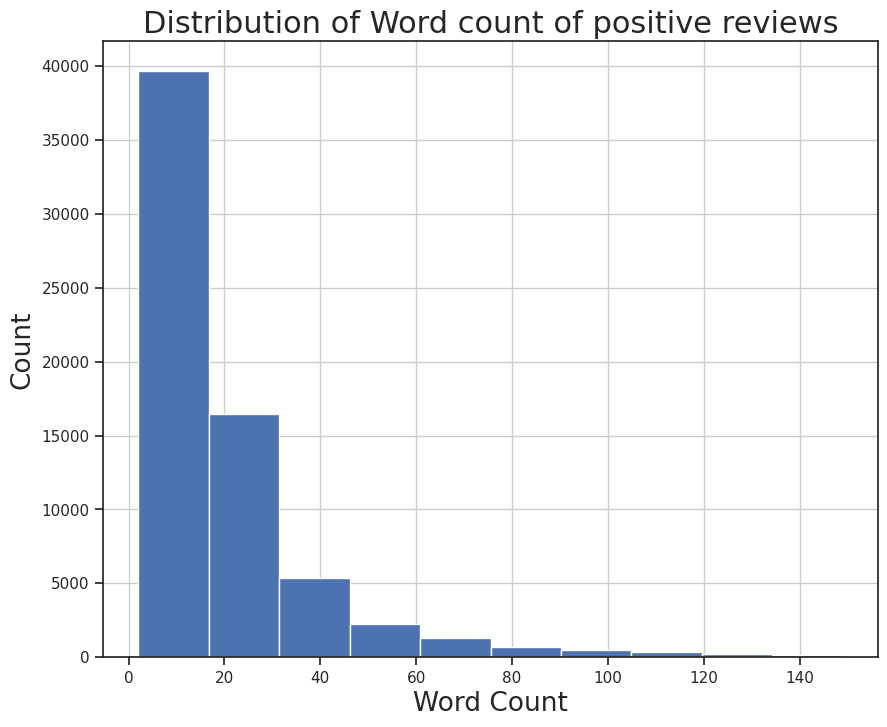

In [ ]:
# Plot distribution of positive review length
review_length = data["pros"].map(lambda x: len(x.split(" ")))
plt.figure(figsize=(10,8))
review_length.loc[review_length < 150].hist()
plt.title("Distribution of Word count of positive reviews")
plt.xlabel('Word Count')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

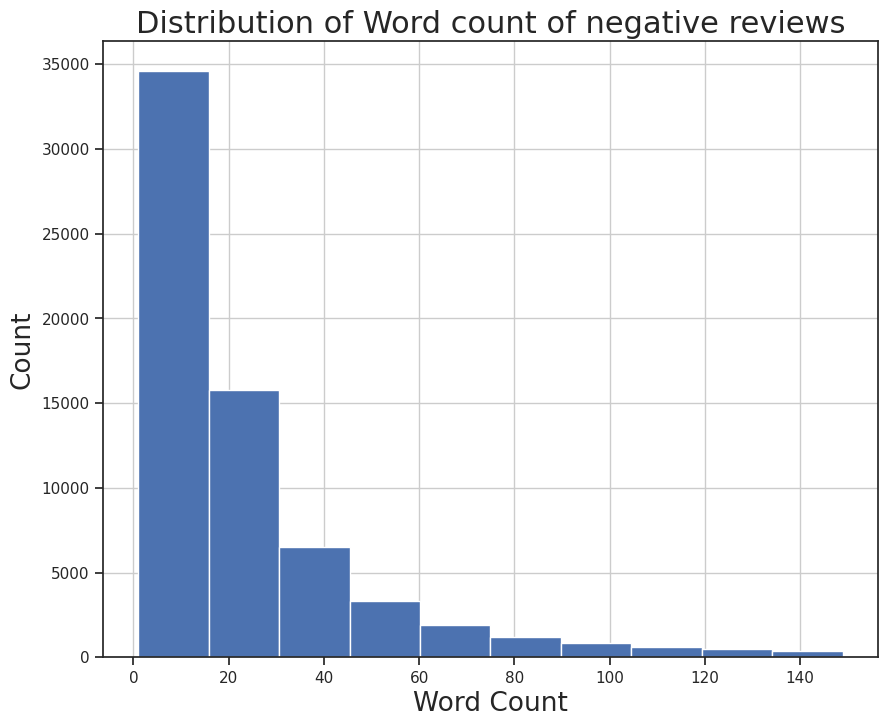

In [ ]:
# Plot distribution of negative review length
review_length = data["cons"].map(lambda x: len(x.split(" ")))
plt.figure(figsize=(10,8))
review_length.loc[review_length < 150].hist()
plt.title("Distribution of Word count of negative reviews")
plt.xlabel('Word Count')
plt.ylabel('Count')

In the above two lines we have tried to understand the word count for both positive and negative reviews. We can clearly see that people tend to write more will writing positive reviews.

We will now create a new call which will be used for understanding and predicting the sentiments of the companies. 


In [ ]:
#classifying ratings as positive or negative
#for overall rating greater than 3 , the sentiment is 1, which is positive
#for overall rating less than or equal to 3, the sentiment is negative, or 0
data['Sentiment'] = np.where(data['overall-ratings'] <= 3,0,1)
data["Sentiment"].value_counts()
#merging the pros and cons columns of the dataset. to further use for prediction 
data["Review"] = data[['pros', 'cons']].apply(lambda x: '.'.join(x), axis=1)
data.head(10)

company  ...                                             Review
0  google  ...  People are smart and friendly.Bureaucracy is s...
1  google  ...  1) Food, food, food. 15+ cafes on main campus ...
2  google  ...  * If you're a software engineer, you're among ...
3  google  ...  You can't find a more well-regarded company th...
4  google  ...  Google is a world of its own. At every other c...
5  google  ...  People are not that busy, so they are nice to ...
6  google  ...  Great working environment. Good work life bala...
7  google  ...  work culture, benefits, growth, people,.No con...
8  google  ...  Great products. Vision you can feel good about...
9  google  ...  Impact driven. Best tech in the world..Size ma...

[10 rows x 19 columns]

### Predictive Modelling

We will now try and understand the average Baseline accuracy before we begin modelling. 

In [ ]:
#Base Model
data["Sentiment"].value_counts()


#1 - 45688
#0 - 21841
45688/(21841+45688)

0.6765685853485169

In [ ]:
#since majority of the data is positively rated (sentiment = 1), we will clasify all data points as 1
positive = len(data[data["Sentiment"] == 1])
total = len(data["Sentiment"])
accuracy = (positive/total)*100
print('The baseline accuracy is %.2f' %accuracy)

The baseline accuracy is 67.66


In [ ]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(data['Review'], data['Sentiment'], \
                                                    test_size=0.2, random_state=0)

print('Load %d training examples and %d test examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 54023 training examples and 13506 test examples. 

Show a review in the training set : 
 Great people, management is awesome.manager support when development has peaked


In [ ]:
#Defining a function which cleans the data - removes stop words and lemmitizes
def cleanText(raw_text, remove_stopwords=True, lemmetization=True, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    #text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    text = raw_text
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if lemmetization==True: 
        #stemmer = SnowballStemmer('english') 
        #words = [stemmer.stem(w) for w in words]
        # Lemmatizataion
        
        lmtzr = WordNetLemmatizer()
        words = [lmtzr.lemmatize(word) for word in words]

    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [ ]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 great people management awesome manager support development peaked


We will first train the data using different methods of tokenizers such as CountVectorizer, TFIDF and Word2Vec to create a corpus. We will then predict the trained models on various predictive models such as Naive Bayes, Logistic Regression and Random Forest. 

## 1. CountVectorizer

In [ ]:
# Fit and transform the training data to a document-term matrix using CountVectorizer

#countvector - tokenizes the text - builds vocabulary - then can make new documents using that vocabulary
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)

print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


Number of features : 27484 

Show some feature names : 
 ['aa', 'angenehmes', 'ball', 'bred', 'cintinue', 'constante', 'decontaminate', 'distraction', 'energetic', 'factually', 'fuel', 'hacker', 'iisc', 'intruder', 'lerner', 'megacorp', 'nebenleistungen', 'organzation', 'phase', 'profiter', 'regionalism', 'runaway', 'sigle', 'stayed', 'teammate', 'troubled', 'utter', 'wither']


Training a Multinomial Naive Bayes model


In [ ]:
# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on test set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [ ]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on test set: 0.7557

AUC score : 0.6838

Confusion Matrix : 
 [[2096 2255]
 [1045 8110]]


Training a Logistic Regression Model

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_countVect, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Evaluate on the validaton set
predictions = lr.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on test set: 0.7617

AUC score : 0.6895

Confusion Matrix : 
 [[2117 2234]
 [ 984 8171]]


## 2. TFIDF Vectorizer

In [ ]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

Number of features : 9019 

Show some feature names : 
 ['aa', 'bruising', 'deduction', 'facility', 'implication', 'merit', 'popular', 'school', 'terribly', 'youtube']


In [ ]:
# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['horrible' 'worst' 'terrible' 'poor' 'joke' 'toxic' 'awful' 'told' 'fear'
 'resume']

Top 10 features with largest coefficients : 
['con' 'amazing' 'sometimes' 'bit' 'best' 'supportive' 'downside' 'great'
 'awesome' 'excellent']


We can observe here that the 10 features with largest coefficients have positive sentiments associated with it. While the smallest coefficients are associated with negative sentiments. This shows that people write more positive reviews and focus more on positive sentiments whike writing workplace reviews. 

In [ ]:
# Evaluate on the LR validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on test set: 0.7697

AUC score : 0.6951

Confusion Matrix : 
 [[2111 2240]
 [ 870 8285]]


In [ ]:
# Evaluate the MNB model on validaton set 
predictions = mnb.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on test set: 0.7519

AUC score : 0.6387

Confusion Matrix : 
 [[1394 2957]
 [ 394 8761]]


In [ ]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression(max_iter=500))]
model = Pipeline(estimators)
# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't
grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)
# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 1, 'tfidf__max_features': None, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuracy on test set: 0.7742

AUC score : 0.6990

Confusion Matrix : 
 [[2121 2230]
 [ 820 8335]]


## 3. Word2Vec

In [ ]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

54023 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['great', 'people', 'management', 'awesome', 'manager', 'support', 'development', 'peaked']


In [ ]:
# Fit parsed sentences to Word2Vec model 

num_features = 300  #embedding dimension                     
min_word_count = 5                
num_workers = 4     #4 worker threads for training  
context = 10        #consider 10 words before and after                                                                                  
downsampling = 1e-3 #dilute frequent words

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Number of words in the vocabulary list : 9199 

Show first 10 words in the vocalbulary list: 
 ['work', 'great', 'people', 'company', 'good', 'benefit', 'get', 'time', 'lot', 'team']


In [ ]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [ ]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Training set : 54023 feature vectors with 300 dimensions
Validation set : 13506 feature vectors with 300 dimensions


In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(trainVector, y_train)
# Evaluate on the validaton set
predictions = lr.predict(testVector)
modelEvaluation(predictions)


Accuracy on test set: 0.7471

AUC score : 0.6636

Confusion Matrix : 
 [[1867 2484]
 [ 932 8223]]


In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on test set: 0.7548

AUC score : 0.6673

Confusion Matrix : 
 [[1834 2517]
 [ 795 8360]]


Our last model is running a simple LSTM neural network on the Reviews column.

In [ ]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 5


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpus
tokenizer.fit_on_texts(X_train_cleaned)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train_cleaned)
sequences_test = tokenizer.texts_to_sequences(X_test_cleaned)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) 
print('X_test shape:', X_test_seq.shape) 
print('y_train shape:', y_train_seq.shape) 
print('y_test shape:', y_test_seq.shape) 

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


X_train shape: (54023, 100)
X_test shape: (13506, 100)
y_train shape: (54023, 2)
y_test shape: (13506, 2)


In [ ]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128, dropout=0.2))
model1.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()


# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

# Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
54023/54023 [==============================] - 280s 5ms/step - loss: 0.5133 - accuracy: 0.7544
Epoch 2/5
54023/54023 [==============================] - 280s 5ms/step - loss: 0.4352 - accuracy: 0.8037
Epoch 3/5
54023/54023 [==============================] - 286s 5ms/step - loss: 0.3850 - accuracy: 0.8277
Epoch 4/5
54023/54023 [==============================] - 290s 5ms/step - loss: 0.3403 - accuracy: 0.8503
Epoch 5/5
13506/13506 [==============================] - 12s 890us/step
Test loss : 0.6136
Test accuracy : 0.7573


In [ ]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) 

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) #weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape) #weight dim of dense layer

Size of weight matrix in the embedding layer :  (20000, 128)
Size of weight matrix in the hidden layer :  (128, 512)
Size of weight matrix in the output layer :  (128, 2)


Training a LSTM model using Word2Vec

In [ ]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.syn0  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) 
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of embedding matrix :  (9199, 300)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """


In [ ]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 5


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train_cleaned)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train_cleaned)
sequences_test = tokenizer.texts_to_sequences(X_test_cleaned)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


X_train shape: (54023, 100)
X_test shape: (13506, 100)
y_train shape: (54023, 2)
y_test shape: (13506, 2)


In [ ]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  if __name__ == '__main__':


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         2759700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 2,979,606
Trainable params: 2,979,606
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
54023/54023 [==============================] - 449s 8ms/step - loss: 0.5099 - accuracy: 0.7546
Epoch 2/5
54023/54023 [==============================] - 451s 8ms/step - loss: 0.4368 - accuracy: 0.8017
Epoch 3/5
54023/54023 [==============================] - 443s 8ms/step - loss: 0.3828 - accuracy: 0.8286
Epoch 4/5
54023/54023 [==============================] - 449s 8ms/step - loss: 0.3277 - accuracy: 0.8574
Epoch 5/5
13506/13506 [==============================] - 23s 2ms/step
Test loss : 0.6434
Test accuracy : 0.7554


In [ ]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #weight dim of dense layer

Size of weight matrix in the embedding layer :  (9199, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)


Lastly, we will create a Word Cloud to visually understand the sentiments of the employees and ex-employees of the six companies. This will show us the most prominent words used to describe positives and negatives of a company. 

In [ ]:
def create_word_cloud(sentiment,company):
    '''
    Using WordCloud to understand the overall sentiment of 
    employees for each company
    '''
    try: 
        #data_review = data.loc[data["company"]==brand]
        data_review = data[["Review","Sentiment","company","pros","cons"]]
        data_review = data_review[data_review["company"]==company]
        #Takes 10% of the data
        data_review_sample = data_review
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = data_review_sample[data_review_sample["Sentiment"]==1]["pros"]
            
        if sentiment == 0:
            df_reviews = data_review_sample[data_review_sample["Sentiment"]==0]["cons"]
            
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english') and word != "n't"]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50,min_font_size=10, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(10,10))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    except: 
        pass

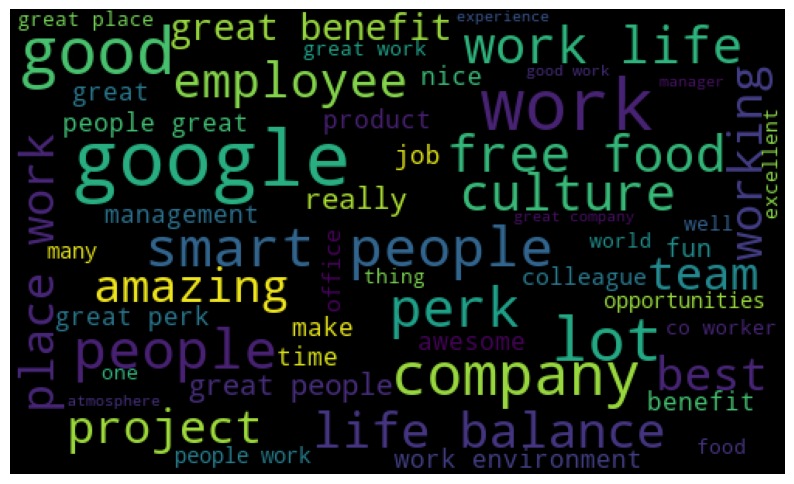

In [ ]:
create_word_cloud(sentiment=1,company="google")

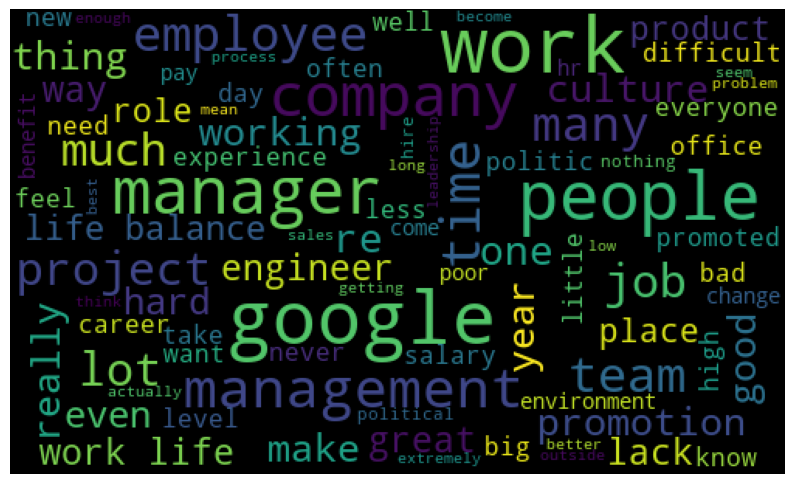

In [ ]:
create_word_cloud(sentiment=0,company="google")

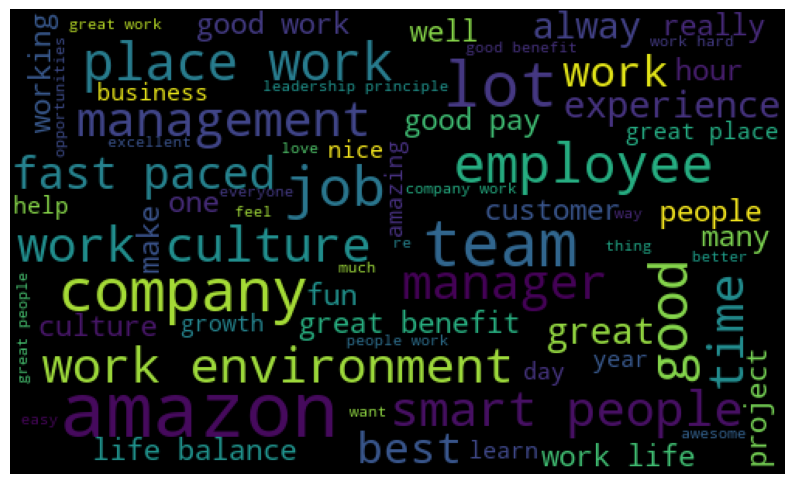

In [ ]:
create_word_cloud(sentiment=1,company="amazon")

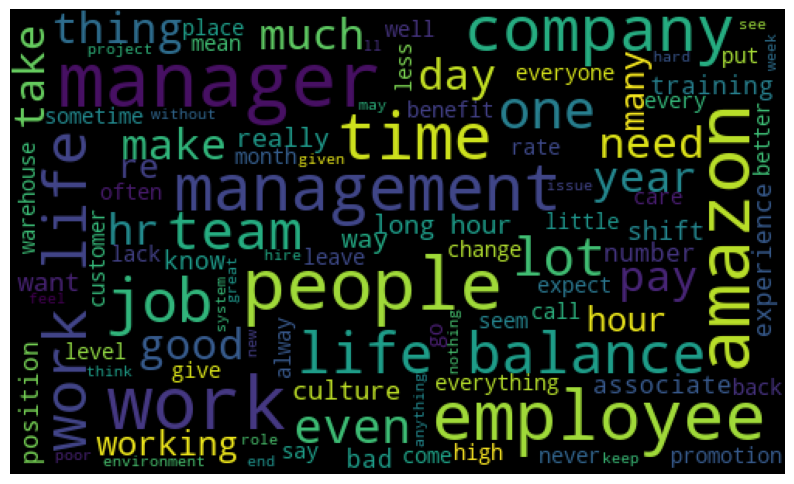

In [ ]:
create_word_cloud(sentiment=0,company="amazon")

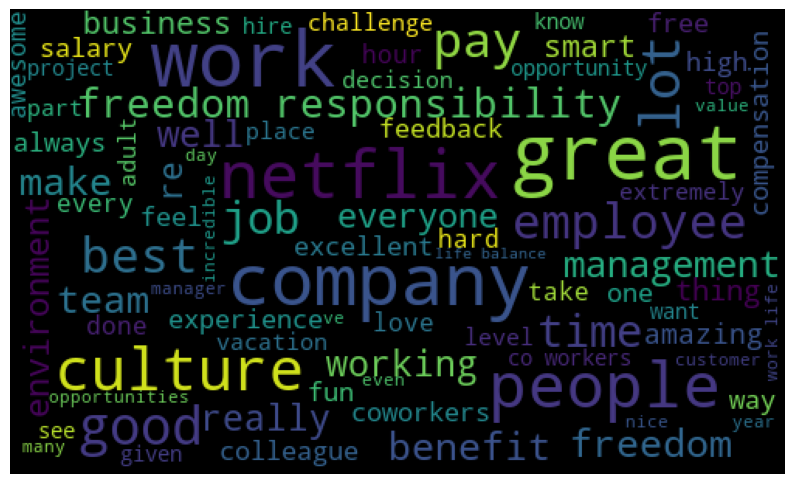

In [ ]:
create_word_cloud(sentiment=1,company="netflix")

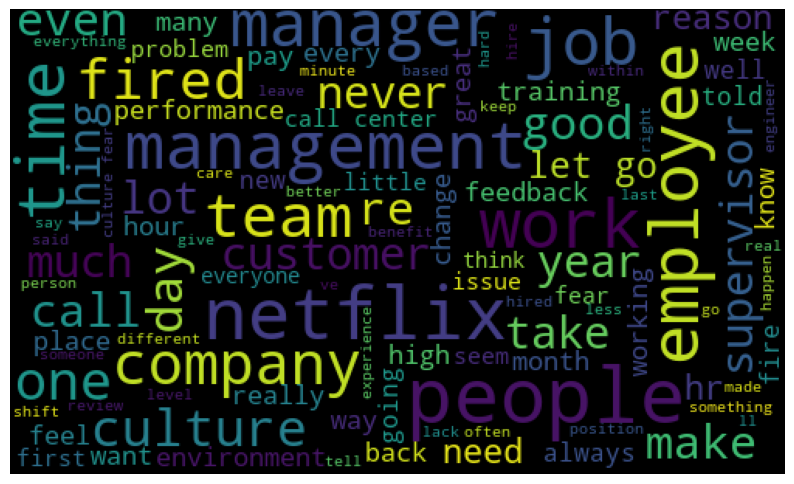

In [ ]:
create_word_cloud(sentiment=0,company="netflix")

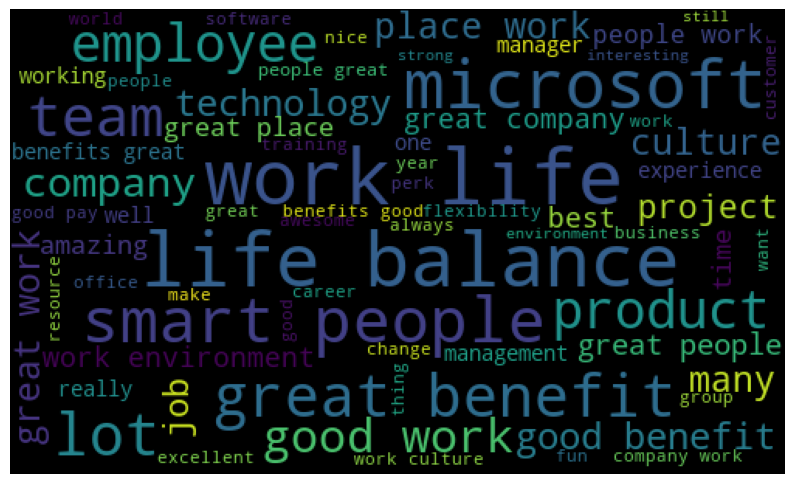

In [ ]:
create_word_cloud(sentiment=1,company="microsoft")

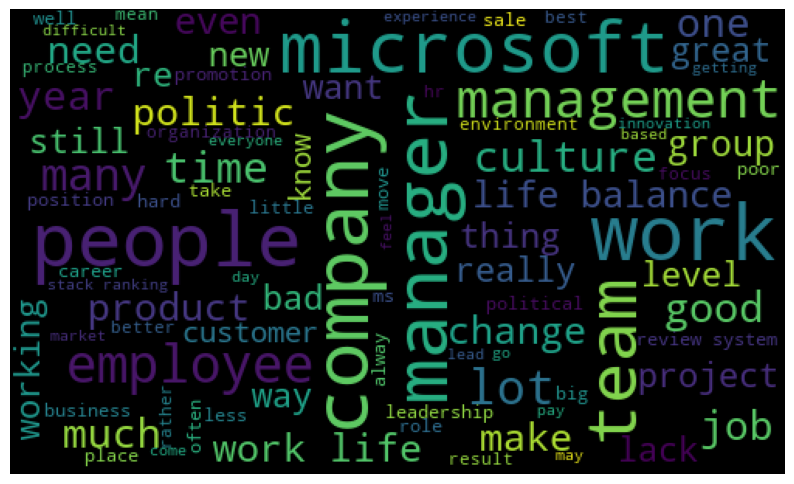

In [ ]:
create_word_cloud(sentiment=0,company="microsoft")

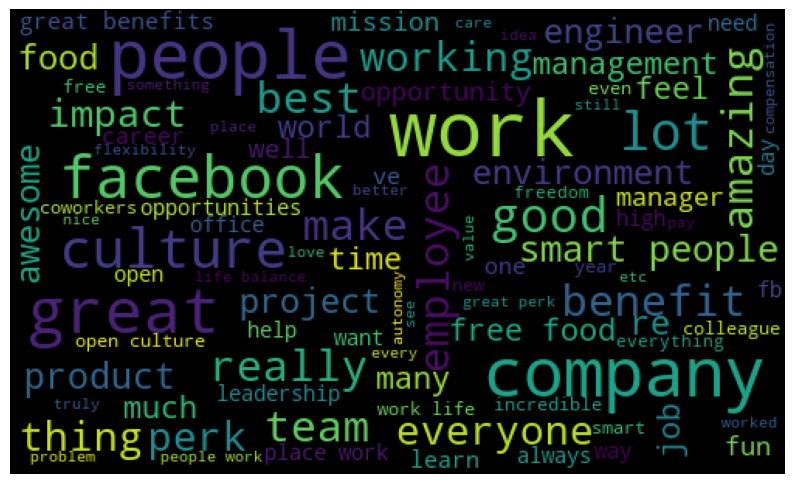

In [ ]:
create_word_cloud(sentiment=1,company="facebook")

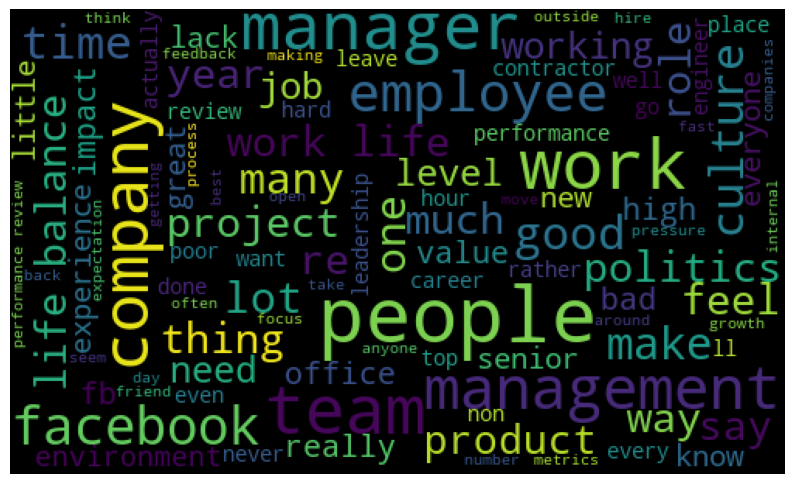

In [ ]:
create_word_cloud(sentiment=0,company="facebook")

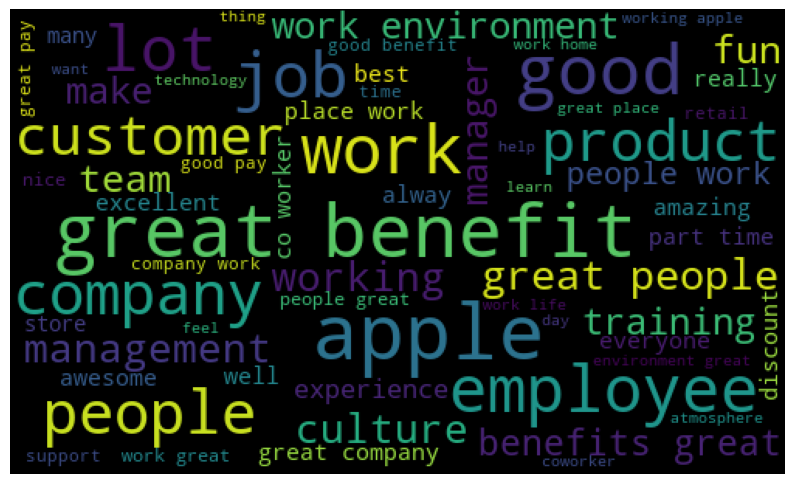

In [ ]:
create_word_cloud(sentiment=1,company="apple")

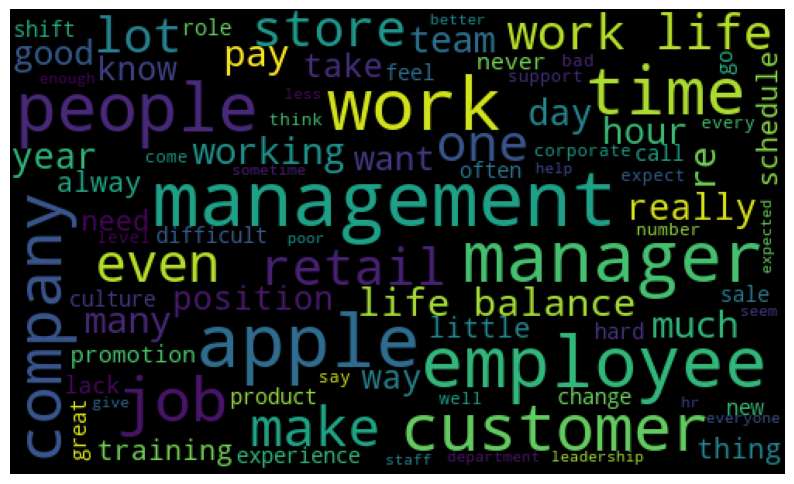

In [ ]:
create_word_cloud(sentiment=0,company="apple")